## 代码测试 notebook

构建测试环境，使能够索引模块路径

In [1]:
import os
import sys
 
cur_dir = os.getcwd()
pkg_rootdir = os.path.dirname(cur_dir)
# pkg_rootdir = os.path.dirname(os.path.dirname(cur_dir))
print(pkg_rootdir)
if pkg_rootdir not in sys.path:
    sys.path.append(pkg_rootdir)

/home/brhu/WorkStation/Programming/Python/detr-s


### 测试 backbone类

In [2]:
# test code for models.backbone
import torch
from models.backbone import Backbone

name = 'resnet18'  # Example backbone name
train_backbone = True  # Example train_backbone value
return_interm_layers = True  # Example return_interm_layers value
dilation = False  # Example dilation value

backbone_instance = Backbone(name, train_backbone, return_interm_layers, dilation)
# 打印模型结构信息
print(backbone_instance)

# torch.save(backbone_instance.state_dict(), 'backbone.pth')

Backbone(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d()
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d()
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d()
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d()
      )
    )
    (layer2): Sequential(
   

### 测试位置编码类

/home/brhu/WorkStation/Programming/Python/detr-s/models/pos_encodeing.py:35: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


torch.Size([2, 256, 25, 25])


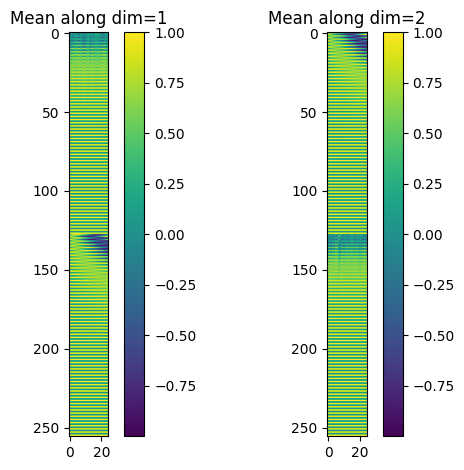

In [3]:
from models.pos_encodeing import PositionEmbeddingSine
import matplotlib.pyplot as plt
from util.misc import NestedTensor

# 创建一个示例输入
batch_size = 2
tensor = torch.randn(batch_size, 25, 25)
# 创建掩码
mask_shape = (batch_size, 25, 25)
mask = torch.rand(mask_shape) > 0.5
# mask = torch.rand(3, 25, 25, dtype=torch.bool)
tensor_list = NestedTensor(tensor, mask)

# 实例化类
pos_embedding = PositionEmbeddingSine(num_pos_feats=128, normalize=True, scale=None)

# 调用 forward 方法计算位置编码
pos_embed = pos_embedding(tensor_list)

print(pos_embed.shape)

# 可视化位置编码结果
# plt.imshow(output[0].mean(dim=0).detach().numpy(), cmap='hot')
# plt.colorbar()
# plt.show()

fig, axs = plt.subplots(1, 2)

# 在第一个子图中绘制图像1
im1 = axs[0].imshow(pos_embed[0].mean(dim=1).detach().numpy(), cmap='viridis')
axs[0].set_title('Mean along dim=1')
fig.colorbar(im1, ax=axs[0])

# 在第二个子图中绘制图像2
im2 = axs[1].imshow(pos_embed[0].mean(dim=2).detach().numpy(), cmap='viridis')
axs[1].set_title('Mean along dim=2')
fig.colorbar(im2, ax=axs[1])

# 调整子图之间的距离
fig.tight_layout()

# 显示图形
plt.show()

### 测试 Transformer类

In [4]:
from models.transformer import Transformer
import torch.nn as nn

# 创建示例输入
src = torch.rand(batch_size, 256, 25, 25)  # 输入序列
# # 创建掩码
# mask_shape = (2, 25, 25)
# mask = torch.rand(mask_shape) > 0.5
tensor = NestedTensor(src, mask)

d_model = src.shape[1]
transformer_instance = Transformer(d_model=d_model, nhead=8, num_encoder_layers=6,
                 num_decoder_layers=6, dim_feedforward=2048, dropout=0.1,
                 activation="relu", normalize_before=False,
                 return_intermediate_dec=False)
num_queries = 100
hidden_dim = d_model
query_embed = nn.Embedding(num_queries, hidden_dim)
print(query_embed)

hs, memory = transformer_instance(tensor.tensors, tensor.mask, query_embed.weight, pos_embed=pos_embed)

print(hs.shape)
print(memory.shape)

Embedding(100, 256)
torch.Size([1, 2, 100, 256])
torch.Size([2, 256, 25, 25])


### 测试 DETR 模型

In [5]:
from models.detr import DETR, PostProcess
from models.backbone import Joiner

backbone = Joiner(backbone_instance, pos_embedding)
backbone.num_channels = backbone_instance.num_channels
transformer = transformer_instance  # 定义您的transformer模型
num_classes = 91  # 定义目标类别数量
num_queries = 100  # 定义查询数量
detr_model = DETR(backbone, transformer, num_classes, num_queries)

# 创建一个示例输入
image = torch.randn(batch_size, 3, 640, 640)  # 输入图像，假设为224x224大小的RGB图像
# samples = [{'tensor': image, 'mask': None}]  # 构建NestedTensor示例
samples = image

output = detr_model(samples)

pred_logits = output['pred_logits']
pred_boxes = output['pred_boxes']

print(pred_logits.shape)
print(pred_boxes.shape)

# 网络结果后处理
postprocess = PostProcess()
detections = postprocess(output, torch.ones(batch_size, 2)*640)

print(detections[0].keys())

torch.Size([2, 100, 92])
torch.Size([2, 100, 4])
dict_keys(['scores', 'labels', 'boxes'])


### 测试匈牙利算法

In [6]:
test_tensor = torch.randn(2, 100, 92)
test_tensor = test_tensor.flatten(0, 1)
print(test_tensor.shape)

test_tensor = test_tensor.softmax(-1)
print(test_tensor.shape)

x1 = torch.tensor([[1, 1, 1, 1], [3, 3, 1, 1], [2, 2, 1, 1]], dtype=float)  # 第一组点的坐标
x2 = torch.tensor([[1.5, 1, 1, 1], [1, 1.5, 1, 1]], dtype=float)  # 第二组点的坐标

distances = torch.cdist(x1, x2, p=2)  # 计算欧氏距离
print(distances)

torch.Size([200, 92])
torch.Size([200, 92])
tensor([[0.5000, 0.5000],
        [2.5000, 2.5000],
        [1.1180, 1.1180]], dtype=torch.float64)


In [10]:
from models.matcher import HungarianMatcher

matcher = HungarianMatcher(cost_class=1, cost_bbox=5, cost_giou=2)

# 创建真实标签
gt_target = detections

i, j = matcher(output, gt_target)

print(i)
print(j)

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
        90, 91, 92, 93, 94, 95, 96, 97, 98, 99]), tensor([68, 72, 27,  3, 53, 89, 74, 86, 38, 40,  1, 99, 11, 46, 24, 13, 47, 26,
        14, 34,  9, 92, 96, 56,  4, 61, 48,  2, 19, 25,  0, 45, 67, 59, 79, 80,
        23, 76, 35, 18, 17, 64, 21, 97, 44, 75, 51, 65, 41, 78, 50, 15, 52, 29,
        54, 90, 36, 57, 70, 93, 43, 66, 55, 63, 83, 62, 32, 94, 30, 84, 91, 39,
        20, 73,  5, 77, 37, 71, 49,  6, 31, 98, 85, 10, 60, 82, 69, 87, 16, 22,
        33,  8, 81, 42, 58, 95, 28,  7, 88, 12]))
(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20